In [76]:
#Anazom
from comprehend import ComprehendDetect
from os import listdir
from os.path import isfile, join, exists
import time
import boto3
import urllib.request, json 
import random
import pandas as pd
import sys 

#Nube de Palabras
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import missingno as msngo
plt.rcParams['figure.figsize'] = (10, 6)
import nltk
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/foco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Funciones de Amazon

In [77]:
def parse_time(seconds):
    parsed_time = seconds
    if seconds < 60:
        return parsed_time
    elif (seconds > 60) and (seconds < 60*60):
        return parsed_time/60
    else:
        return seconds/3600

def audio_to_text(audio_uri, lang, region, access_key, secret_key):
    start = time.time()
    transcribe = boto3.client(
        'transcribe', 
        region_name = "sa-east-1",
        aws_access_key_id = access_key,
        aws_secret_access_key = secret_key
    )
    job_name = "test"+str(random.randint(0,1000000000000000))
    
    transcribe.start_transcription_job(
        TranscriptionJobName=job_name,
        Media={'MediaFileUri': audio_uri},
        MediaFormat='mp3',
        LanguageCode=lang
    )
    while True:
        status = transcribe.get_transcription_job(TranscriptionJobName=job_name)
        if status['TranscriptionJob']['TranscriptionJobStatus'] in ['COMPLETED', 'FAILED']:
            break
    end = time.time()    

    #url_path = status["TranscriptionJob"]["Transcript"]["TranscriptFileUri"]
    #with urllib.request.urlopen(url_path) as url:
    #    data = json.loads(url.read().decode())
        
    #result = {"executedTime": parse_time(end - start), "data": data}    

    if status['TranscriptionJob']['TranscriptionJobStatus'] == 'COMPLETED':
           data = pd.read_json(status['TranscriptionJob']['Transcript']['TranscriptFileUri'])
    #data = result['TranscriptionJob']['Transcript']['TranscriptFileUri']

    return data['results'][1][0]['transcript']
    

def upload_to_aws(local_file, bucket, s3_file, access_key, secret_key):
    s3 = boto3.client('s3', aws_access_key_id=access_key,
                      aws_secret_access_key=secret_key)

    s3.upload_file(local_file, bucket, s3_file)


def sentiment_analysis(text, size, region, access_key, secret_key):
     

    comp_detect = ComprehendDetect(boto3.client(
        'comprehend', 
        region_name = region,
        aws_access_key_id = access_key,
        aws_secret_access_key = secret_key
    ))   


    
    if isinstance(text, str) and len(text) > 0 and sys.getsizeof(text) < 5000:
        languages = comp_detect.detect_languages(text)
        lang_code = languages[0]['LanguageCode']  
        entities = comp_detect.detect_entities(text, lang_code)
        phrases = comp_detect.detect_key_phrases(text, lang_code)
        sentiment = comp_detect.detect_sentiment(text, lang_code)
        result = {"entities": entities[:size], "key_phrases": phrases[:size], "sentiment":sentiment}
        return sentiment['SentimentScore']


## Parametros

In [78]:
bucket = 'focobucket'
sa_region = 'sa-east-1'
us_region = 'us-east-1'
ACCESS_KEY_ID = 'XXXXXXXXXXXXXXXXXXXX'
SECRET_ACCESS_KEY = 'XXXXXXXXXXXXXXXXXX'
local_files_path = "/home/foco/Documentos/ArticulosPersonalesPython/AudioTexto/AudioArticulo/GitHub"

In [16]:
#Funcion para conectarse a Amazon
s3 = boto3.client('s3', region_name = sa_region,aws_access_key_id=ACCESS_KEY_ID, aws_secret_access_key=SECRET_ACCESS_KEY)

In [17]:
#Funcion que lee los archivos locales, los lleva a S3, ejecuta la transcripcion de Audio a Texto y luego el analisis de sentimiento
def read_mp3_files(folder):
    onlyfiles = [f for f in listdir(folder) if isfile(join(folder, f))]
    onlyfiles = filter(lambda x:x.endswith((".mp3")), onlyfiles)    

    result = []
    
    for mp3_file in onlyfiles:  

        print(mp3_file)
        s3.upload_file(f'{folder}/{mp3_file}', bucket, mp3_file)
        text_result = audio_to_text(f's3://{bucket}/{mp3_file}', 'es-ES', sa_region, 
                                    ACCESS_KEY_ID, SECRET_ACCESS_KEY)
 
        sent_analysis_dict = sentiment_analysis(text_result, 3, us_region, ACCESS_KEY_ID, SECRET_ACCESS_KEY)

        
        print("#"*30)
        print(sent_analysis_dict)

        if sent_analysis_dict != None:
            result.append({
                "NombreAudio": mp3_file,
                "Texto":text_result,
                "ScorePositive":sent_analysis_dict['Positive'],
                "ScoreNegative":sent_analysis_dict['Negative'],
                "ScoreNeutral":sent_analysis_dict['Neutral'],
                "ScoreMix":sent_analysis_dict['Mixed'],
                "Status": "Success"
            })
        else:
            result.append({
                "NombreAudio": mp3_file,
                "Texto":text_result,
                "ScorePositive":0,
                "ScoreNegative":0,
                "ScoreNeutral":0,
                "ScoreMix":0,
                "Status": "Fail"
            })    

    print('Listo')
    return result

In [79]:
#DataFrame Resultado del Proceso
df = pd.DataFrame(read_mp3_files("/home/foco/Documentos/ArticulosPersonalesPython/AudioTexto/GitHub/AudioArticulo"), columns =['NombreAudio','Texto','ScorePositive','ScoreNegative','ScoreNeutral','ScoreMix','Status'])

yt1s.com - CLIENTE ENOJADO POR LLAMADA DEL BANCO.mp3
##############################
{'Positive': 0.001420009764842689, 'Negative': 0.8461830019950867, 'Neutral': 0.15164828300476074, 'Mixed': 0.0007487530237995088}
Listo


In [80]:
df

,NombreAudio,Texto,ScorePositive,ScoreNegative,ScoreNeutral,ScoreMix,Status
0,yt1s.com - CLIENTE ENOJADO POR LLAMADA DEL BAN...,"Hola. Hola, qué tal? Buenas noches. Tengo entr...",0.00142,0.846183,0.151648,0.000749,Success


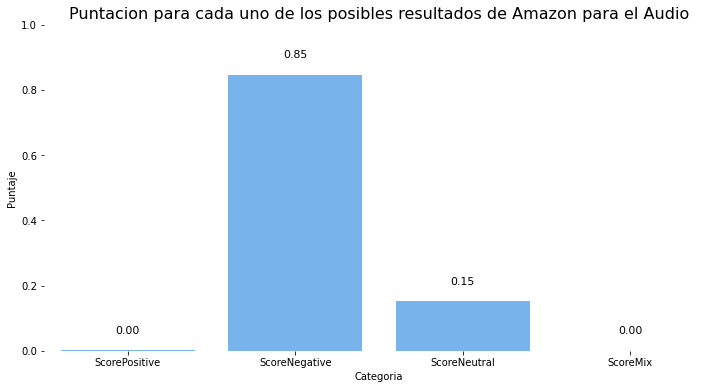

In [98]:
datos = df[['ScorePositive','ScoreNegative','ScoreNeutral','ScoreMix']].stack().reset_index().drop(columns =['level_0'])
datos = datos.rename(columns ={'level_1':'Categoria',0: 'Puntaje'})


x_axis = datos['Categoria']
y_axis = datos['Puntaje']

plt.figure(figsize = (12,6))
sns.set_color_codes("pastel")
sns.set_color_codes("muted")
g=sns.barplot(x_axis, y_axis, color='#66b3ff')
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,1)

plt.title('Puntacion para cada uno de los posibles resultados de Amazon para el Audio', fontsize = 16)
sns.despine(left=True, bottom=True)

In [100]:
list(df['Texto'])

['Hola. Hola, qué tal? Buenas noches. Tengo entrada. Karen. Vale, Valenzuela quien habla? Me estoy comunicando el Banco Patagonia. Mi nombre es Christian Gregorio. No sé si tengo el gusto de hablar con Karen Me. Llamaron a hacer y les dije que no me interesa nada del banco. Se habían comunicado con ustedes Karen, No sé si han podido llegar a contactarlo, a comentar un poco acerca de lo que tenemos a su disposición. Le. Dije que no me interesa nada del banco. No lo fruto y también absoluta tal. Luego te pagan por hablar un tiempo largo porque te registra la sana de un tiempo largo. Yo dejo libre el teléfono y que bueno, yo ya me realidad, pero si no cortemos porque tengo muchas cosas que hacer. Pero Yo no, en realidad nada del banco porque no quiero nada de ningún banco. Bien, no me interesa nada de ningún banco de este país. Venía robada, que vota este hijo de ni puta de matriz del horror y que te vas a la puta madre que lo pario, Macri su banco de niebla y toda la gente venía que pret

## Descripcion de Texto (Nube de Palabras)

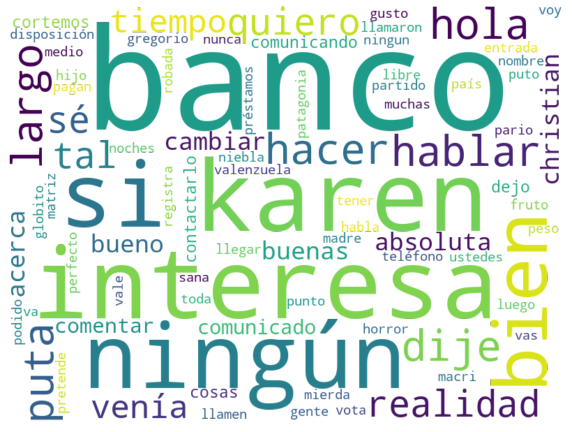

In [101]:
NUMERO_PALABRAS = 10000
lista_de_textos = df['Texto']

# instanciamos un objeto
count_vectorizer=CountVectorizer(stop_words =stop_words, max_features=NUMERO_PALABRAS)
# Implementamos los pasos fit y transform
count_vectorizer_fit = count_vectorizer.fit_transform(lista_de_textos)

# Extraemos tokens (palabras)
words = count_vectorizer.get_feature_names()
# extraemos frecuencia
words_freq = count_vectorizer_fit.toarray().sum(axis=0)

df2 = pd.DataFrame({'words': words, 'freq':words_freq}, columns=['words', 'freq'])

#df2.sort_values('freq', ascending = False).head(10)
data = dict(zip(df2['words'].tolist(), df2['freq'].tolist()))

wc = WordCloud(width=800, height=600, mode='RGBA', background_color=None).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
##plt.title('Nube de Palabra del Audio')
plt.axis('off')
plt.show()

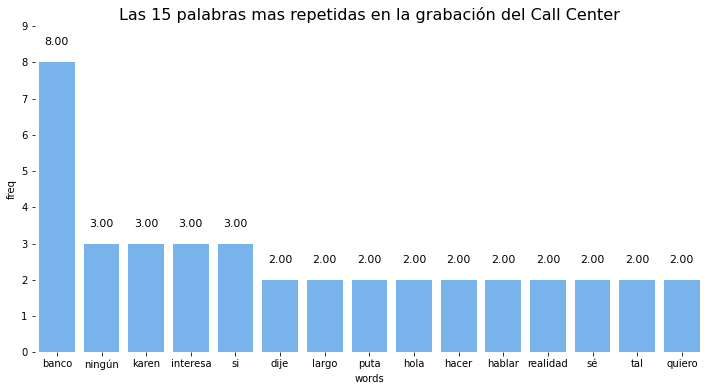

In [102]:
df2 = df2.sort_values('freq', ascending = False)
df2.head(15)

#sns.countplot(df2.head(15), x = 'freq')

x_axis = df2['words'][:15]
y_axis = df2['freq'][:15]

plt.figure(figsize = (12,6))
sns.set_color_codes("pastel")
sns.set_color_codes("muted")
g=sns.barplot(x_axis, y_axis, color='#66b3ff')
ax=g
#annotate axis = seaborn axis
for p in ax.patches:
             ax.annotate("%.2f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=11, color='black', xytext=(0, 20),
                 textcoords='offset points')
_ = g.set_ylim(0,9)

plt.title('Las 15 palabras mas repetidas en la grabación del Call Center', fontsize = 16)
sns.despine(left=True, bottom=True)